In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
#input_path = "/run/media/wasserstoff/Fedora Linux New/torrent/filtered/2.csv"
input_path = "/tf/data/1.csv"

In [3]:
data = pd.read_csv(input_path)

In [4]:
data.head()

title  \
0  Evaluation of Right Ventricular Function and M...   
1  Effects of Barley Starch Level in Diet on Ferm...   
2  Quantification of cortisol and its metabolites...   
3  Advances in Vision-Based Gait Recognition: Fro...   
4  Functional Nanohybrids and Nanocomposites Deve...   

                          container_title  is_referenced_by_count  \
0            Journal of Clinical Medicine                       1   
1                                 Animals                       3   
2  Analytical and Bioanalytical Chemistry                       2   
3                                 Sensors                       3   
4                               Molecules                      10   

   reference_count  published  author_count  \
0               36       2022            13   
1               37       2022             5   
2               47       2022             9   
3              105       2022             3   
4              179       2022             6   

                                            abstract  
0  Right ventricular (RV) function is one of the ...  
1  This study aimed to explore the effects of dif...  
2  Abstract The objective of the current research...  
3  Identifying people’s identity by using behavio...  
4  World population growth, with the consequent c...

In [162]:
len(data)/2

319824.5

In [5]:
train_column = "abstract"

In [6]:
import re

def standardise_text(text):
    text = re.sub( r"[^\w\s\']", "", text)
    text = text.strip(" ")
    text = text.lower()
    return text

data[train_column] = [standardise_text(str(x)) for x in data[train_column]]

In [7]:
from typing import List

def filter_stop_word(text: str, stop_words: List[str]):
    words = text.split(" ")
    return " ".join([x for x in words if x not in stop_words])

with open("/tf/stop_words_english.txt", "r") as file:
    stop_words = file.read().split("\n") 

data[train_column] = [filter_stop_word(str(x), stop_words) for x in progress_bar(data[train_column])]

In [8]:
data.head()

title  \
0  Evaluation of Right Ventricular Function and M...   
1  Effects of Barley Starch Level in Diet on Ferm...   
2  Quantification of cortisol and its metabolites...   
3  Advances in Vision-Based Gait Recognition: Fro...   
4  Functional Nanohybrids and Nanocomposites Deve...   

                          container_title  is_referenced_by_count  \
0            Journal of Clinical Medicine                       1   
1                                 Animals                       3   
2  Analytical and Bioanalytical Chemistry                       2   
3                                 Sensors                       3   
4                               Molecules                      10   

   reference_count  published  author_count  \
0               36       2022            13   
1               37       2022             5   
2               47       2022             9   
3              105       2022             3   
4              179       2022             6   

                                            abstract  
0  ventricular rv function critical factors progn...  
1  study aimed explore effects levels barley star...  
2  abstract objective current develop liquid chro...  
3  identifying peoples identity behavioral biomet...  
4  population growth consequent consumption prima...

In [63]:
from keras.src.preprocessing.text import Tokenizer

token = Tokenizer(num_words=10000)
token.fit_on_texts(data[train_column])
X = token.texts_to_sequences(data[train_column])

In [64]:
from itertools import chain
np.max(list(chain(*X)))

9999

In [65]:
# a function to load our vector model as dictionary
def load_glove_model(input_filepath):
    glove_model = dict()
    with open(input_filepath,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

In [66]:
GLOVE_PATH = "/tf/data/glove.6B.300d.txt"
GLOVE_DIM = 300
glove_model = load_glove_model(GLOVE_PATH)

400000 words loaded


In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, np.array(data["is_referenced_by_count"]), test_size=0.2, train_size=0.8)

In [164]:
import tensorflow.keras.preprocessing.sequence as sequence
maxlen = 100 # cut or appends each review to have this number of words

# turn the list of integers into a 2D matrix of shape (samples, maxlen)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen,truncating='post', padding='post')
x_test = sequence.pad_sequences(X_test, maxlen=maxlen, truncating='post', padding='post')

print("now all {} reviews have a length of {} words.".format(x_train.shape[0], x_train.shape[1]))

print("the first review:\n", x_train[0])

now all 511719 reviews have a length of 100 words.
the first review:
 [1025 4984 5138 1229  132  198 3991  132    6 7216 4411 2743 1025 8934
  198  467 1745 1081    7   43 2945  244 1116 6311  336  934 1433 1375
  218 3172   91  116  550   74  520  516 3751  529   47  474 1538  487
  312   67 2819 5443   47  176   61  767   64  249 1375  440 2058 1025
 8934  198  467    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [165]:
vocab_size = np.max(list(chain(*X))) + 1 #len(token.word_index)+1
vocab_size

10000

In [166]:
# we want to import the vectors of Glove into the embedding_layer  of a neural network

# this requires an embedding_matrix which has a  shape of (10000, 100)
# the first number is the size of the vocabulary we asked for when we imported the imdb reviews
# the second number is the size of the individual embedding vectors from the GloVe model we have loaded
embedding_matrix = np.zeros((vocab_size, GLOVE_DIM)) 

# we loop through the whole vocabulary of the imdb reviews (which has more than 10000 words)
for word, i in token.word_index.items():

    if i < vocab_size:       # if the token is smaller than the threshold we set at import
        # we try to get the corresponding embedding from glove
        embedding_vector = glove_model.get(word) 
        # if this embedding exists, we feed it into our embedding_layer matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
        # Words not found in the embedding index will all be zeros    

In [167]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

print("GloVe covers {}% of the {} most frequent words in the titles"
      .format(nonzero_elements/vocab_size*100, vocab_size))

GloVe covers 94.92% of the 10000 most frequent words in the titles


In [172]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(vocab_size, GLOVE_DIM, input_length = maxlen)) # i.e. 10000, 100, 300
model.add(Conv1D(128, 5, activation='relu'))  # 128 feature maps, each computed with a window of size 5 
                                              # on a vector of dimension 100  -> 296 (300 - 4) values per review 
model.add(GlobalAveragePooling1D())           # combine results from each review to one number
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation="linear")) 
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          3000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           192128    
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                     

In [173]:
model.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', "accuracy"])

# we load our GloVe model into the embedding layer
model.layers[0].set_weights([embedding_matrix])
# the GloVe embedding is not changed by the training
model.layers[0].trainable = False 

In [174]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          3000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           192128    
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                     

In [175]:
history = model.fit(x_train, y_train, 
                    epochs=10,
                    batch_size=32, 
                    validation_data=(x_test, y_test))

Epoch 1/10
15992/15992 [==============================] - 106s 7ms/step - loss: 140.3617 - mean_squared_error: 140.3617 - accuracy: 0.3629 - val_loss: 126.4389 - val_mean_squared_error: 126.4389 - val_accuracy: 0.3647
Epoch 2/10
15992/15992 [==============================] - 62s 4ms/step - loss: 133.3113 - mean_squared_error: 133.3113 - accuracy: 0.3626 - val_loss: 126.4894 - val_mean_squared_error: 126.4894 - val_accuracy: 0.3647
Epoch 3/10
15992/15992 [==============================] - 60s 4ms/step - loss: 119.5465 - mean_squared_error: 119.5465 - accuracy: 0.3621 - val_loss: 133.4269 - val_mean_squared_error: 133.4269 - val_accuracy: 0.3640
Epoch 4/10
15992/15992 [==============================] - 59s 4ms/step - loss: 94.9102 - mean_squared_error: 94.9102 - accuracy: 0.3617 - val_loss: 136.1278 - val_mean_squared_error: 136.1278 - val_accuracy: 0.3634
Epoch 5/10
15992/15992 [==============================] - 59s 4ms/step - loss: 72.6731 - mean_squared_error: 72.6731 - accuracy: 0.36

In [179]:
# evaluate model performance
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: {:.4f}".format(score[0]))
print("Test accuracy: {:.4f}".format(score[1]))

Test loss: 179.7191
Test accuracy: 179.7191


In [180]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Train loss: {:.4f}".format(score[0]))
print("Train accuracy: {:.4f}".format(score[1]))

Train loss: 67.3872
Train accuracy: 67.3872


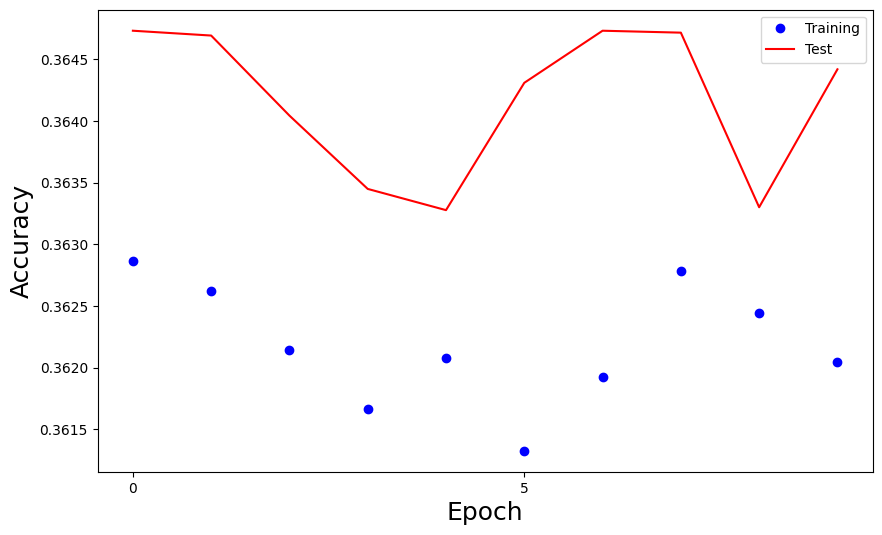

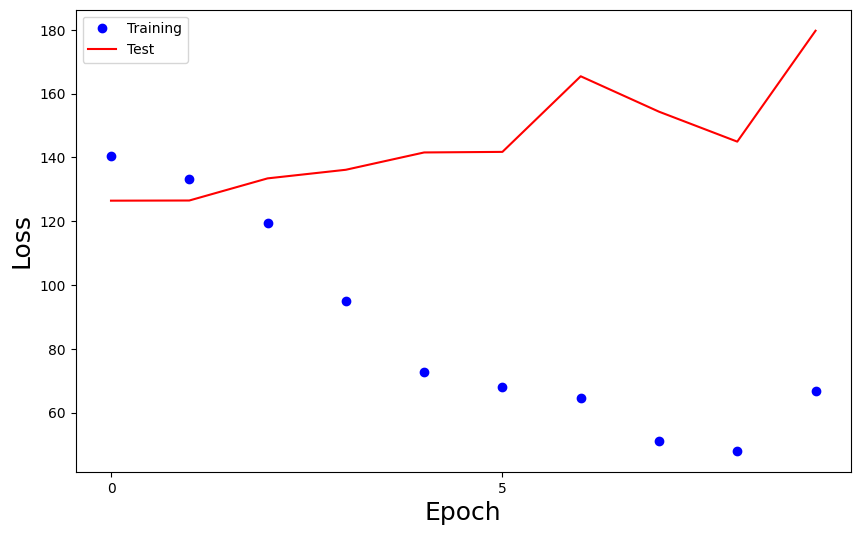

In [181]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))


plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.xticks(np.arange(0, 10, step=5))
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.xticks(np.arange(0, 10, step=5))
plt.legend()
plt.show()

In [159]:
y_pred = model.predict(x_test)

9995/9995 [==============================] - 7s 742us/step


In [160]:
np.mean(y_pred)

3.913591

In [145]:
1/len(data) * np.sum(np.power(np.ones(np.shape(data["is_referenced_by_count"])) - data["is_referenced_by_count"], 2))

151.36149825920154

In [82]:
import numpy as np

rng = np.random.default_rng()
rdm = rng.integers(low=0, high=max(data["is_referenced_by_count"]), size=len(data["is_referenced_by_count"]))

1/len(data) * np.sum(np.power(rdm - data["is_referenced_by_count"], 2))

4212059.132145911

In [ ]:
1/len(data) * np.square(np.sum(np.power(np.ones(np.shape(data["is_referenced_by_count"])) * np.mean(data["is_referenced_by_count"]) - data["is_referenced_by_count"], 2)))